In [121]:
# подключение библиотек 
import cv2 
import numpy as np 
from google.colab.patches import cv2_imshow 
import random 
import skimage
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ***Генерация изображений***

In [80]:
# создание пустого массива под изображения 
clear_image = np.zeros((256,256,3))

In [81]:
# создание градиента цвета
def get_grad(image, key):
    image_with_grad = image.copy()
    i=0
    k=0
    key = random.randint(120, 255)
    for _ in range(50):
        image_with_grad[:,0+i:50+i] = (50+k, 255-k/8, key)
        i += 5
        k += 10

    return image_with_grad

In [82]:
# добавление объектов на изображение
def get_detail(image, count):
    image_with_detail = image.copy()
    h,w,_ = image_with_detail.shape

    for i in range(count):
        coord = (random.randint(0, h), random.randint(0,w))
        color = (random.randint(0, 255),random.randint(0, 255), random.randint(0, 255))

        cv2.circle(image_with_detail, coord, random.randint(0,10), color, -1)
    return image_with_detail

In [83]:
# подсчет кол-во деталей (границ)
def count_detail(image):
    count_contour = 0 
    x = cv2.Sobel(image,cv2.CV_16S,1,0)  
    y = cv2.Sobel(image,cv2.CV_16S,0,1)  
    absX = cv2.convertScaleAbs(x)   # Перенести обратно на uint8  
    absY = cv2.convertScaleAbs(y) 
    dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY) 
    ret, thresh = cv2.threshold(dst, 50, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    count_contour = len(contours)
    return count_contour

In [84]:
# группа с малым количеством деталей
group_1 = [get_detail(get_grad(clear_image, random.randint(0, 255)), 10) for i in range(3)]

In [85]:
# группа с средним количеством деталей
group_2 = [get_detail(get_grad(clear_image, random.randint(0, 255)), 80) for i in range(3)]

In [86]:
# группа с большим количеством деталей
group_3 = [get_detail(get_grad(clear_image, random.randint(0, 255)), 300) for i in range(3)]

In [87]:
# подсчет кол-во деталий на изображении 
for i in range(len(group_1)):
    print(count_detail(group_1[i]))
print('-----------------------------------')
for i in range(len(group_2)):
    print(count_detail(group_2[i]))
print('-----------------------------------')
for i in range(len(group_3)):
    print(count_detail(group_3[i]))
print('-----------------------------------')

20
30
28
-----------------------------------
131
145
166
-----------------------------------
370
360
359
-----------------------------------


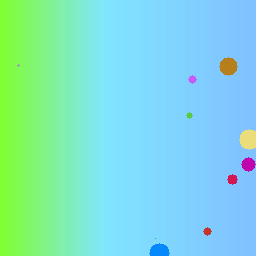

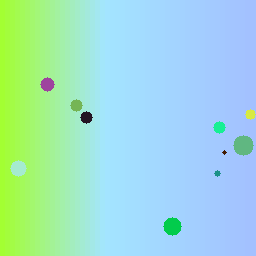

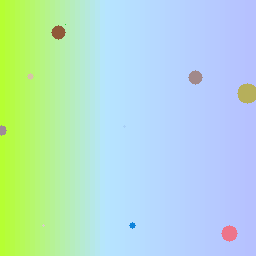

In [ ]:
for image in group_1:
   cv2_imshow(image)

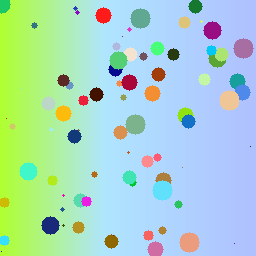

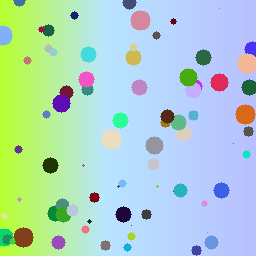

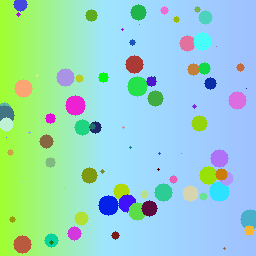

In [89]:
for image in group_2:
    cv2_imshow(image)

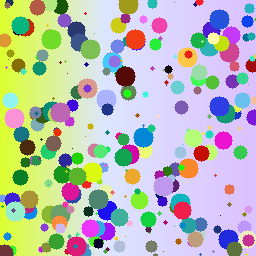

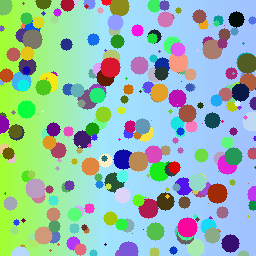

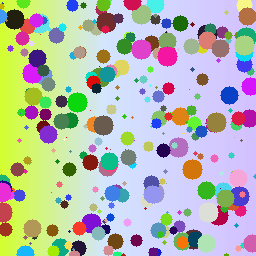

In [90]:
for image in group_3:
    cv2_imshow(image)

# ***Добавление шумов***

In [91]:
# добавление шума
def get_noise(image):
    image_ = image.copy()
    noise = np.random.normal(5, 15, image.shape)
    return image_+noise


In [92]:
# добавление шумов
group_1_noise = [get_noise(image) for image in group_1]

In [93]:
# добавление шумов
group_2_noise = [get_noise(image) for image in group_2]

In [94]:
# добавление шумов
group_3_noise = [get_noise(image) for image in group_3]

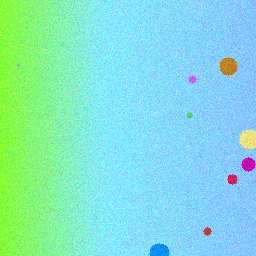

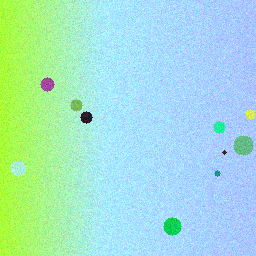

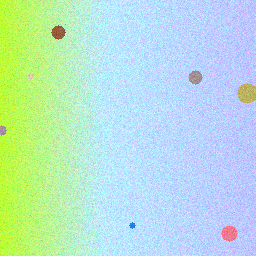

In [95]:
for image in group_1_noise:
    cv2_imshow(image)

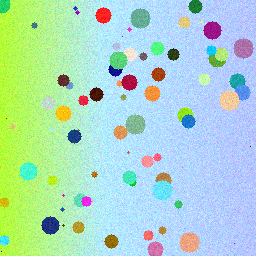

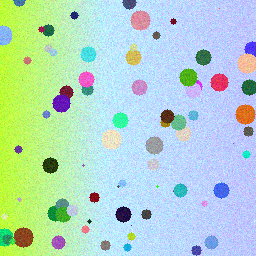

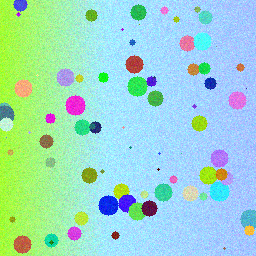

In [96]:
for image in group_2_noise:
    cv2_imshow(image)

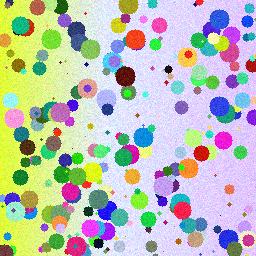

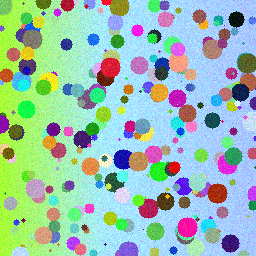

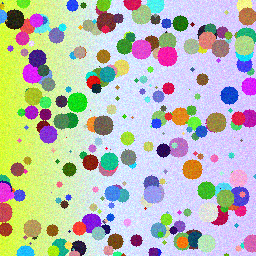

In [97]:
for image in group_3_noise:
    cv2_imshow(image)

# ***Расчет метрик***

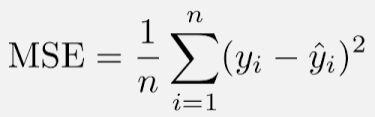

In [98]:
# метрика MSE
def MSE(img1, img2):
    return np.mean((img1 - img2)**2)


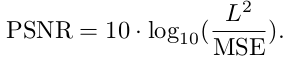

In [106]:
# метрика PSNR
def PSNR(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = MSE(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(255.0 / math.sqrt(mse))

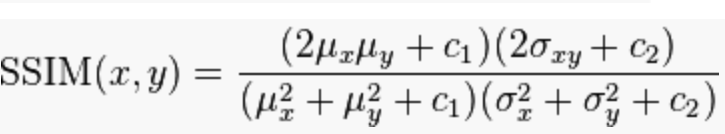

In [107]:
# метрика SSIM
def SSIM(img1, img2):
    C1 = (0.01 * 255)**2
    C2 = (0.03 * 255)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()

In [108]:
MSE_1 = ['MSE']
PSNR_1 = ['PSNR']
SSIM_1 = ['SSIM']
for i in range(3):
    MSE_1.append(MSE(group_1[i], group_1_noise[i]))
    PSNR_1.append(PSNR(group_1[i], group_1_noise[i]))
    SSIM_1.append(SSIM(group_1[i], group_1_noise[i]))

In [109]:
df1 = pd.DataFrame(({'func':[], 'Image_L1': [], 'Image_L2': [], 'Image_L3': []}))
df1.loc[ len(df1.index )] = MSE_1
df1.loc[ len(df1.index )] = PSNR_1
df1.loc[ len(df1.index )] = SSIM_1


In [110]:
df1

,func,Image_L1,Image_L2,Image_L3
0,MSE,249.367585,250.196763,250.293267
1,PSNR,24.162404,24.147987,24.146312
2,SSIM,0.269577,0.270420,0.263652


In [112]:
MSE_2 = ['MSE']
PSNR_2 = ['PSNR']
SSIM_2 = ['SSIM']
for i in range(3):
    MSE_2.append(MSE(group_2[i], group_2_noise[i]))
    PSNR_2.append(PSNR(group_2[i], group_2_noise[i]))
    SSIM_2.append(SSIM(group_2[i], group_2_noise[i]))

In [113]:
df2 = pd.DataFrame(({'func':[], 'Image_M1': [], 'Image_M2': [], 'Image_M3': []}))
df2.loc[ len(df2.index )] = MSE_2
df2.loc[ len(df2.index )] = PSNR_2
df2.loc[ len(df2.index )] = SSIM_2


In [114]:
df2

,func,Image_M1,Image_M2,Image_M3
0,MSE,247.954233,249.987555,251.080781
1,PSNR,24.187088,24.151620,24.132669
2,SSIM,0.392157,0.391296,0.386015


In [116]:
MSE_3 =  ['MSE']
PSNR_3 = ['PSNR']
SSIM_3 = ['SSIM']
for i in range(3):
    MSE_3.append(MSE(group_3[i], group_3_noise[i]))
    PSNR_3.append(PSNR(group_3[i], group_3_noise[i]))
    SSIM_3.append(SSIM(group_3[i], group_3_noise[i]))

In [119]:
df3 = pd.DataFrame(({'func':[], 'Image_H1': [], 'Image_H2': [], 'Image_H3': []}))
df3.loc[ len(df3.index )] = MSE_3
df3.loc[ len(df3.index )] = PSNR_3
df3.loc[ len(df3.index )] = SSIM_3

In [120]:
df3

,func,Image_H1,Image_H2,Image_H3
0,MSE,250.867442,250.118412,250.414315
1,PSNR,24.136361,24.149347,24.144212
2,SSIM,0.614749,0.599356,0.607435


# ***Вывод***


В результате добавления Гауссовского шума к 3-м типам изображения
Среднее значение MSE и PSNR оставалось на одинаковом уровна, метрика SSIM наибольшая при изображениях с большим кол-вом деталей, а наименьша при самом малом количестве

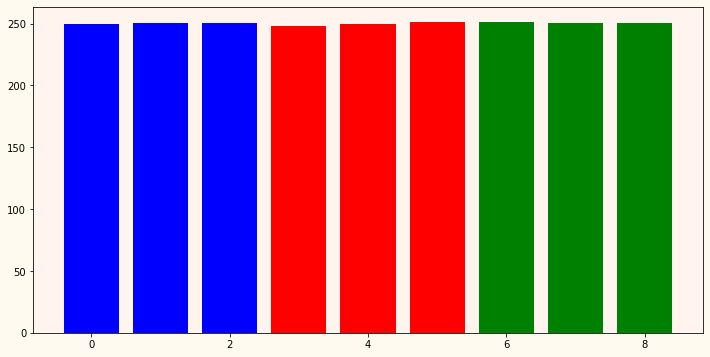

In [124]:
x = np.arange(0,9 )
y = MSE_1[1:]+MSE_2[1:]+MSE_3[1:]

fig, ax = plt.subplots()

color_rectangle = ['b','b','b','r','r','r','g','g','g']    # RGB
ax.bar(x, y, color = color_rectangle)

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

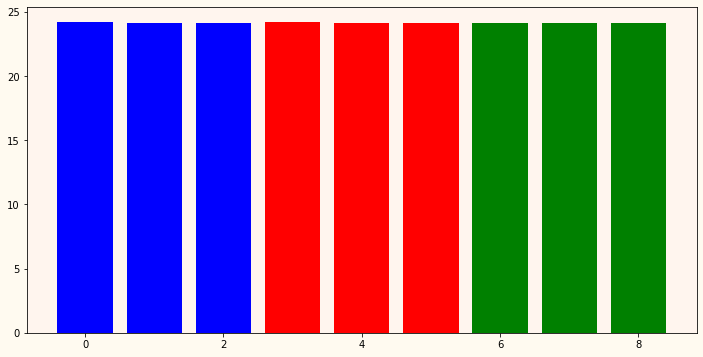

In [125]:
x = np.arange(0,9 )
y = PSNR_1[1:]+PSNR_2[1:]+PSNR_3[1:]

fig, ax = plt.subplots()

color_rectangle = ['b','b','b','r','r','r','g','g','g']    # RGB
ax.bar(x, y, color = color_rectangle)

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')

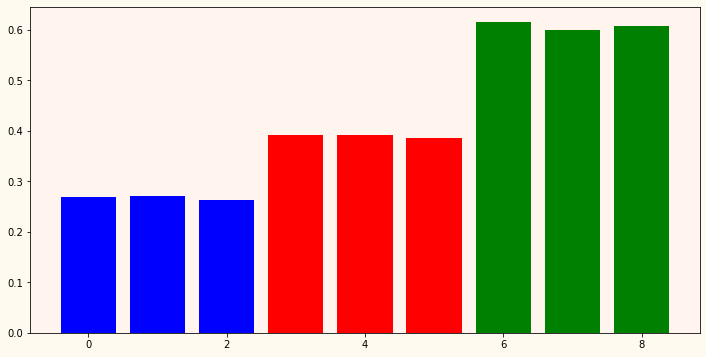

In [126]:
x = np.arange(0,9 )
y = SSIM_1[1:]+SSIM_2[1:]+SSIM_3[1:]

fig, ax = plt.subplots()

color_rectangle = ['b','b','b','r','r','r','g','g','g']    # RGB
ax.bar(x, y, color = color_rectangle)

fig.set_figwidth(12)    #  ширина и
fig.set_figheight(6)    #  высота "Figure"
fig.set_facecolor('floralwhite')
ax.set_facecolor('seashell')